# environment

## define opponent

In [5]:
from ray.rllib.agents import ppo
import gym
import numpy as np


hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
    'action_space': gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32),
    'observation_space': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
}


op_agent = ppo.PPOTrainer(config=hc_configs)
op_agent.restore('../checkpoints/v2.2/checkpoint_000031/checkpoint-31')

2022-04-13 16:19:24,936	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
2022-04-13 16:19:29,569	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-04-13 16:19:29,588	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/v2.2/checkpoint_000031/checkpoint-31
2022-04-13 16:19:29,589	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 31, '_timesteps_total': 6199380, '_time_total': 1542.2936189174652, '_episodes_total': 4604}


In [8]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=12.0,
                 n_cps = 200,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='SILVERSTONE_TRAIN',
                 safe_padding=0.3,
                 laps = 1.0,
                 opponent=op_agent
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.opponent = opponent
        self.prev_state = None
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2, 3])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/ss{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/ss-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=2)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
#             start_idx = np.random.randint(0, len(self.checkpoints))
#             start_point = self.checkpoints[start_idx]
            
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [0., 0., np.pi+1]
            
        else:
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [0., 0., np.pi+1]
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        op_start_point = [1.0, 1.0, np.pi+1]
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point,
                op_start_point
            ])
        )
        
        self.t = 0
        self.prev_state = self.to_vector_state(obs) 
        return self.prev_state
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        scanner = scanner[3*70:3*290]
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        th = action[1]*np.pi/6
        
        op_act = self.opponent.compute_single_action(self.prev_state, explore=False)
        op_v = op_act[0]*(self.max_v/2)+(self.max_v/2)
        op_th = op_act[1]*np.pi/6
        
        act = np.array([[th, act_v], [op_th, op_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        self.prev_state = next_state
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps or obs['lap_counts'][1] == self.laps:
            ego_t = obs['lap_times'][0]  
            op_t = obs['lap_times'][0]
            
            if obs['lap_counts'][1] == self.laps:
                reward = -1
                print(f"op agent win! on {self.map_path} got reward {self.cum_r} in {ego_t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            
            else:
                reward = +1
                print(f"ego agent win! on {self.map_path} got reward {self.cum_r} in {ego_t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([0.16789923, 0.16794119, 0.16853741, 0.16754939, 0.16793354,
       0.1681067 , 0.16823773, 0.16876209, 0.16796159, 0.16872837,
       0.16999829, 0.17738072, 0.17594006, 0.17590536, 0.1680191 ,
       0.1668668 , 0.16811748, 0.1672431 , 0.1758069 , 0.17647094,
       0.17628442, 0.17529042, 0.1775146 , 0.17555218, 0.17477916,
       0.18072535, 0.18016769, 0.17924076, 0.17840288, 0.18316466,
       0.18443207, 0.18347849, 0.19343349, 0.19097431, 0.19238814,
       0.18931767, 0.18974798, 0.19023975, 0.18917909, 0.2012295 ,
       0.20060594, 0.20046437, 0.19757442, 0.19619984, 0.19734727,
       0.19924197, 0.19873742, 0.20807072, 0.20686986, 0.20688534,
       0.20869765, 0.20843356, 0.21806241, 0.21675535, 0.21912106,
       0.22448327, 0.22850827, 0.23020562, 0.2301418 , 0.22984355,
       0.23391257, 0.24446521, 0.24641228, 0.25065798, 0.25646419,
       0.25673314, 0.25512509, 0.26065259, 0.27336778, 0.27270943,
       0.28227547, 0.28102394, 0.29012256, 0.29944045, 0.29770

# training

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
# trainer.restore('./checkpoints/v1.9/checkpoint_000116/checkpoint-116')

print(trainer.config)
rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/v2.2_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save(f"{models_path}/v2.2")
        print("checkpoint saved at", cp)


2022-04-13 13:05:30,214	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
2022-04-13 13:05:30,215	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-04-13 13:05:30,216	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=7503) 2022-04-13 13:05:36,344	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=7502) 2022-04-13 13:05:36,652	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorE

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_u

2022-04-13 13:06:49,529	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:-0.9314984709480122
checkpoint saved at ../checkpoints/v2.2/checkpoint_000001/checkpoint-1
episode: 1 reward:-0.8910935738444193
episode: 2 reward:-0.734984984984985
episode: 3 reward:-0.4551835853131749
episode: 4 reward:0.16125461254612553
episode: 5 reward:0.8821243523316062
checkpoint saved at ../checkpoints/v2.2/checkpoint_000006/checkpoint-6
episode: 6 reward:2.858999999999995
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 85.02000000000659. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 84.2600000000062. Finish reward: 0.1. Padding punish: -0.05
episode: 7 reward:3.7799999999999954
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 88.3700000000083. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 88.3800000

(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 78.7800000000034. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 78.64000000000333. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.05000000000002 in 77.0300000000025. Finish reward: 0.1. Padding punish: -0.35
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 80.32000000000419. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 78.88000000000345. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.550000000000004 in 82.41000000000525. Finish reward: 0.1. Padding punish: -0.7500000000000001
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20

(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 79.16000000000359. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 72.79000000000033. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.65000000000001 in 70.99999999999942. Finish reward: 0.1. Padding punish: -0.65
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 67.29999999999752. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 72.16000000000001. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 70.50999999999917. Finish reward: 0.1. Padding punish: 0
episode: 16 reward:11.276999999999994
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TR

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 67.26999999999751. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 74.11000000000101. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN2 got reward 14.999999999999963 in 69.08999999999844. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 69.80999999999881. Finish reward: 0.1. Padding punish: -0.15000000000000002
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 67.55999999999766. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 69.18999999999849. Finish reward: 0.1. Padding punish: -0.15000000000000002
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_

(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 65.2999999999965. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 66.05999999999689. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 64.7099999999962. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 64.319999999996. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 62.47999999999614. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN2 got reward 11.44999999999997 in 67.93999999999785. Finish reward: 0.1. Padding punish: -0.35
episode: 21 reward:12.620499999999987
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRA

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 64.27999999999598. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.200000000000017 in 63.93999999999585. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.4 in 65.8799999999968. Finish reward: 0.1. Padding punish: -0.9000000000000002
episode: 23 reward:12.818999999999999
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 61.32999999999637. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 61.639999999996306. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 62.37999999999616. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 64.37999999999603. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.050000000000004 in 64.95999999999633. Finish reward: 0.1. Padding punish: -1.2500000000000004
episode: 25 reward:13.906500000000003
checkpoint saved at ../checkpoints/v2.2/checkpoint_000026/checkpoint-26
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 65.54999999999663. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 64.19999999999594. Finish reward: 0.1. Padding punish: -0.2
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 60.329999999996566. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 63.26999999999598. Fi

(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN2 got reward 13.699999999999964 in 61.87999999999626. Finish reward: 0.1. Padding punish: -0.2
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 62.70999999999609. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 18.199999999999953 in 64.03999999999586. Finish reward: 0.1. Padding punish: -2.1000000000000005
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 60.72999999999649. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 63.38999999999596. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 61.6599999999963. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40

(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 60.79999999999647. Finish reward: 0.1. Padding punish: 0
episode: 29 reward:14.376180000000003
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 61.01999999999643. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.299999999999997 in 62.699999999996095. Finish reward: 0.1. Padding punish: -0.8000000000000002
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.700000000000006 in 62.189999999996196. Finish reward: 0.1. Padding punish: -0.39999999999999997
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 59.889999999996654. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 59.75999999999668. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker p

(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 61.939999999996246. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN2 got reward 11.799999999999974 in 61.46999999999634. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 58.219999999996986. Finish reward: 0.1. Padding punish: 0
episode: 31 reward:15.910500000000004
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.80000000000001 in 60.1599999999966. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 59.229999999996785. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 60.229999999996586. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.14999999999999 in 59.50999999999673. Finish reward: 0.1. Padding punish: -0.9500000000000003
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 59.81999999999667. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN2 got reward 10.999999999999977 in 61.05999999999642. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 59.45999999999674. Finish reward: 0.1. Padding punish: -0.15000000000000002
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.000000000000018 in 60.239999999996584. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 61.21999999999639. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_

(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.34999999999716. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.219999999997185. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.34999999999716. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 56.29999999999737. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 18.85 in 59.01999999999683. Finish reward: 0.1. Padding punish: -1.2500000000000004
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.679999999997094. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.45 in 113.0000000000209. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.55 in 58.53999999999692. Finish reward: 0.1. Padding punish: -0.5499999999999999
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.6599999999973. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.000000000000018 in 59.23999999999678. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 58.81999999999687. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 59.54999999999672. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.67999999999729. Finish reward: 0.1.

(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.950000000000006 in 57.20999999999719. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 57.68999999999709. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.25000000000002 in 56.53999999999732. Finish reward: 0.1. Padding punish: -0.15000000000000002
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.77999999999727. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 57.79999999999707. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.18999999999719. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_T

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 57.369999999997155. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 57.43999999999714. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.850000000000012 in 59.48999999999673. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.70999999999709. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.469999999997135. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 18.099999999999987 in 55.959999999997436. RETURNED
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.82999999999726.

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.150000000000006 in 58.179999999996994. Finish reward: 0.1. Padding punish: -0.9500000000000003
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN2 got reward 13.999999999999966 in 58.129999999997004. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 16.899999999999974 in 59.44999999999674. Finish reward: 0.1. Padding punish: -2.1000000000000005
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.259999999997376. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.69999999999729. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 58.85999999999686. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRA

(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.78999999999727. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 4.65 in 59.379999999996755. Finish reward: 0.1. Padding punish: -1.5500000000000007
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.399999999999995 in 58.50999999999693. Finish reward: 0.1. Padding punish: -0.7000000000000001
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 59.579999999996716. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 5.849999999999995 in 72.90000000000039. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 57.719999999997086. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 59.5199

(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.25999999999718. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 17.69999999999998 in 52.17999999999819. RETURNED
episode: 47 reward:14.306500000000003
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 56.84999999999726. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 57.17999999999719. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 14.799999999999963 in 41.93000000000023. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.269999999997374. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.24999999999758. F

(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.26999999999757. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.909999999997446. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 5.399999999999997 in 18.61000000000011. RETURNED
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 11.699999999999974 in 57.679999999997094. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 55.34999999999756. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.29999999999737. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.6 in 56.069999999997414. Finish reward: 0.1. Padd

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.52999999999752. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN2 got reward 3.600000000000002 in 13.35999999999976. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 57.73999999999708. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.199999999999985 in 57.919999999997046. Finish reward: 0.1. Padding punish: -1.1000000000000003
episode: 51 reward:13.465499999999999
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.159999999997595. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.83999999999766. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got rewa

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.05000000000002 in 57.769999999997076. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.98999999999743. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.519999999997324. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.559999999997714. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 56.319999999997364. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.70000000000001 in 56.32999999999736. RETURNED
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 55.33999999999756. Finish r

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 54.52999999999772. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.85000000000001 in 56.04999999999742. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 14.699999999999948 in 46.409999999999336. RETURNED
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.34999999999736. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.05000000000002 in 55.43999999999754. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 54.809999999997665. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 56.619999999997304

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.74999999999768. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.150000000000013 in 55.709999999997486. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.950000000000017 in 54.499999999997726. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.400000000000002 in 54.37999999999775. Finish reward: 0.1. Padding punish: -0.9000000000000002
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.650000000000013 in 56.169999999997394. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.75999999999787. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on

episode: 61 reward:13.740000000000002
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 57.269999999997175. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.000000000000014 in 55.07999999999761. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 54.57999999999771. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 2.500000000000001 in 57.6599999999971. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.200000000000003 in 56.719999999997285. Finish reward: 0.1. Padding punish: -1.1000000000000003
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 54.909999999997645. Finish reward: 0.1. Padding punish: -0.05
(RolloutWorker pid=7481) agent on .

(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.51999999999792. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.800000000000008 in 55.309999999997565. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.100000000000012 in 57.55999999999712. Finish reward: 0.1. Padding punish: -0.2
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 54.89999999999765. Finish reward: 0.1. Padding punish: -0.05
episode: 63 reward:13.289999999999997
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.099999999998005. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.599999999999998 in 56.17999999999739. Finish reward: 0.1. Padding punish: -0.7000000000000001
(RolloutWorker pid=7486) age

(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 54.41999999999774. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 18.699999999999996 in 52.45999999999813. RETURNED
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 15.89999999999996 in 44.0699999999998. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 53.07999999999801. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.20999999999818. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.199999999999992 in 54.38999999999775. Finish reward: 0.1. Padding punish: -0.9000000000000002
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.92999999999804. Finish reward: 0.1. Paddin

(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.6299999999981. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.52999999999812. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.800000000000008 in 55.259999999997575. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 54.88999999999765. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.4 in 54.16999999999779. Finish reward: 0.1. Padding punish: -0.9000000000000002
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 52.96999999999803. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN2 got reward 1.2 in 6.04999999

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 54.199999999997786. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.22999999999818. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.35999999999815. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 52.099999999998204. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 53.649999999997895. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.650000000000013 in 53.96999999999783. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.70999999999828. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.650000000000013 in 51.79999999999826. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 51.42999999999834. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN3 got reward 18.84999999999998 in 53.56999999999791. Finish reward: 0.1. Padding punish: -1.2500000000000004
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 53.38999999999795. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.32999999999836. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRA

(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.70000000000001 in 52.51999999999812. Finish reward: 0.1. Padding punish: -0.39999999999999997
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.129999999998596. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.21999999999838. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.500000000000007 in 52.399999999998144. Finish reward: 0.1. Padding punish: -0.6
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.750000000000004 in 53.65999999999789. Finish reward: 0.1. Padding punish: -0.5499999999999999
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.06999999999841. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TR

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 4.300000000000001 in 53.00999999999802. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 52.489999999998126. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 51.47999999999833. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 3.5000000000000018 in 13.079999999999766. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.6199999999983. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 52.21999999999818. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.389999999998345. Finish r

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.850000000000005 in 51.27999999999837. Finish reward: 0.1. Padding punish: -0.5499999999999999
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 51.15999999999839. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.26999999999857. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.16999999999859. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.900000000000016 in 53.75999999999787. Finish reward: 0.1. Padding punish: -0.39999999999999997
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.40999999999834. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1

episode: 80 reward:9.925579999999995
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.15999999999839. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 18.49999999999998 in 53.46999999999793. Finish reward: 0.1. Padding punish: -1.6000000000000008
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.91999999999824. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.200000000000017 in 53.38999999999795. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.31999999999836. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.70999999999828. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN3 got reward 2

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 50.70999999999848. Finish reward: 0.1. Padding punish: -0.3
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 50.939999999998435. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.96999999999863. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 52.16999999999819. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 14.699999999999964 in 38.680000000000874. RETURNED
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 50.939999999998435. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.50999999999852. Fi

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.139999999998594. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.69999999999848. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 4.65 in 18.62000000000011. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.95000000000001 in 50.34999999999855. Finish reward: 0.1. Padding punish: -0.44999999999999996
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.600000000000012 in 51.22999999999838. Finish reward: 0.1. Padding punish: -0.49999999999999994
episode: 85 reward:9.261499999999995
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.150000000000016 in 51.32999999999836. Finish reward: 0.1. Padding punish: -0.15000000000000002
(RolloutWorker pid=7467) agent on ../maps/SIL

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.039999999998614. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 4.899999999999999 in 15.18999999999972. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.150000000000016 in 49.529999999998715. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 50.129999999998596. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.879999999998645. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 51.189999999998385. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.900000000000013 in 51.49999999999832. Finish

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 50.46999999999853. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.249999999999996 in 49.81999999999866. Finish reward: 0.1. Padding punish: -0.7500000000000001
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.90999999999864. Finish reward: 0.1. Padding punish: 0
episode: 90 reward:8.894960000000005
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 50.31999999999856. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 13.599999999999968 in 34.910000000001624. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.929999999998635. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got rewa

(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.399999999999997 in 17.159999999999883. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.80000000000001 in 49.30999999999876. Finish reward: 0.13800000000024823. Padding punish: -0.6
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 50.779999999998466. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.99999999999882. Finish reward: 0.2000000000002359. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.79999999999886. Finish reward: 0.24000000000022795. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.33999999999875. Finish reward: 0.13200000000024945. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1

(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 2.0000000000000004 in 8.109999999999872. RETURNED
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 7.799999999999984 in 22.980000000000793. RETURNED
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.519999999998916. Finish reward: 0.2960000000002168. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.53999999999891. Finish reward: 0.2920000000002176. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 1.9000000000000006 in 7.099999999999893. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 4.6 in 13.80999999999975. RETURNED
episode: 96 reward:7.825480000000004
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN3 got reward 10.399999999999979 in 28.770000000001698. RETURNED
(RolloutWorker pid=7478) agent on ..

(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.88999999999884. Finish reward: 0.22200000000023154. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.78999999999906. Finish reward: 0.4420000000001878. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 9.499999999999982 in 26.17000000000129. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 0 in 1.0100000000000007. STOPPED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.45999999999873. Finish reward: 0.10800000000025421. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.050000000000015 in 51.26999999999837. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 49.0899999999988. Finish rewa

(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.05000000000001 in 49.75999999999867. Finish reward: 0.1. Padding punish: -0.25
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.079999999999. Finish reward: 0.3840000000001993. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 2.9500000000000015 in 10.629999999999818. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.650000000000006 in 48.279999999998964. Finish reward: 0.34400000000020725. Padding punish: -0.44999999999999996
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 50.479999999998526. Finish reward: 0.1. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.000000000000014 in 49.86999999999865. Finish reward: 0.1. Padding punish: -0.1
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got re

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 8.399999999999986 in 22.77000000000076. RETURNED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 16.29999999999996 in 40.17000000000058. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.98999999999882. Finish reward: 0.20200000000023552. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.750000000000007 in 50.00999999999862. Finish reward: 0.1. Padding punish: -0.35
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.500000000000007 in 50.50999999999852. Finish reward: 0.1. Padding punish: -0.6
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.00000000000001 in 48.05999999999901. Finish reward: 0.3880000000001985. Padding punish: -0.39999999999999997
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 11.699999999999966 in 32.28

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.349999999999994 in 49.44999999999873. Finish reward: 0.11000000000025381. Padding punish: -0.7500000000000001
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.74999999999907. Finish reward: 0.4500000000001862. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 4.100000000000001 in 13.219999999999763. RETURNED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.550000000000008 in 49.529999999998715. Finish reward: 0.1. Padding punish: -0.7500000000000001
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 6.199999999999994 in 18.43000000000008. RETURNED
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.87999999999904. Finish reward: 0.42400000000019133. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward

(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN3 got reward 12.399999999999972 in 48.73999999999887. Finish reward: 0.25200000000022554. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.43999999999913. Finish reward: 0.5120000000001739. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.750000000000007 in 50.44999999999853. Finish reward: 0.1. Padding punish: -0.35
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.099999999999999 in 16.069999999999713. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.18999999999918. Finish reward: 0.5620000000001639. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.40999999999914. Finish reward: 0.5180000000001727. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.050000000000015 in 48.63999999999889. Finish reward: 0.27200000000022156. Padding punish: -0.05
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN2 got reward 20.30000000000002 in 49.03999999999881. Finish reward: 0.1920000000002375. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 49.35999999999875. Finish reward: 0.12800000000025022. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.0999999999992. Finish reward: 0.5800000000001603. Padding punish: 0
episode: 111 reward:8.540200000000036
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.119999999999195. Finish reward: 0.5760000000001612. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.87999999999904. Finish reward: 0.

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 48.14999999999899. Finish reward: 0.3700000000002021. Padding punish: -0.15000000000000002
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN3 got reward 4.100000000000001 in 12.679999999999774. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.000000000000007 in 47.97999999999902. Finish reward: 0.4040000000001953. Padding punish: -0.39999999999999997
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.119999999998996. Finish reward: 0.3760000000002009. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN2 got reward 18.74999999999997 in 49.48999999999872. Finish reward: 0.1020000000002554. Padding punish: -1.5500000000000007
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.05999999999901. Finish reward: 0.3880000000001985. Padding puni

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.719999999999075. Finish reward: 0.456000000000185. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.17999999999918. Finish reward: 0.5640000000001635. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN2 got reward 12.94999999999997 in 49.05999999999881. Finish reward: 0.1880000000002383. Padding punish: -0.35
episode: 116 reward:7.1700600000000225
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.48999999999912. Finish reward: 0.5020000000001759. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN3 got reward 2.150000000000001 in 7.669999999999881. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.89999999999904. Finish reward: 0.42000000000019216. Padding punish: 0
(RolloutWo

(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 14.299999999999965 in 36.560000000001295. RETURNED
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN2 got reward 13.199999999999957 in 37.320000000001144. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.959999999999226. Finish reward: 0.6080000000001547. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.64999999999909. Finish reward: 0.4700000000001822. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 11.599999999999975 in 29.250000000001773. RETURNED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 19.500000000000007 in 50.589999999998504. Finish reward: 0.1. Padding punish: -0.8000000000000002
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.13999999999919. Finish reward: 0.5

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.84999999999925. Finish reward: 0.6300000000001504. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 3.400000000000004 in 13.139999999999764. RETURNED
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN3 got reward 20.100000000000016 in 47.65999999999909. Finish reward: 0.4680000000001826. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 7.39999999999999 in 20.86000000000046. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 12.199999999999973 in 31.700000000002156. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.15999999999899. Finish reward: 0.3680000000002025. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 47.78999999999906. Finish reward: 0.442000000

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.869999999998846. Finish reward: 0.22600000000023074. Padding punish: 0
episode: 124 reward:7.724500000000022
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN3 got reward 3.700000000000002 in 12.099999999999786. RETURNED
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.969999999999224. Finish reward: 0.6060000000001552. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.83999999999925. Finish reward: 0.63200000000015. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN3 got reward 7.699999999999989 in 21.570000000000572. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.82999999999905. Finish reward: 0.43400000000018935. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TR

episode: 127 reward:6.1330654205607535
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.78999999999906. Finish reward: 0.4420000000001878. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.050000000000015 in 48.25999999999897. Finish reward: 0.3480000000002065. Padding punish: -0.35
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.9999999999999999 in 4.709999999999944. RETURNED
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.1999999999999975 in 15.829999999999707. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN3 got reward 6.449999999999994 in 20.640000000000427. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 1.5000000000000002 in 6.7699999999999. RETURNED
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.05000000000002 in 47.869999999999045. Finish reward: 0.426000000

(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 3.5000000000000018 in 11.849999999999792. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.75999999999907. Finish reward: 0.4480000000001866. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.49999999999912. Finish reward: 0.5000000000001762. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 12.549999999999967 in 33.28000000000195. RETURNED
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 14.599999999999964 in 37.15000000000118. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 12.749999999999972 in 33.73000000000186. RETURNED
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.02999999999921. Finish reward: 0.5940000000001575. Padding punish: 0
(RolloutWorker p

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.119999999999195. Finish reward: 0.5760000000001612. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.4999999999999995 in 4.629999999999946. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.019999999999214. Finish reward: 0.5960000000001572. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.72999999999907. Finish reward: 0.45400000000018537. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.0899999999992. Finish reward: 0.58200000000016. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 9.99999999999998 in 28.7800000000017. RETURNED
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.539

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.97999999999922. Finish reward: 0.6040000000001555. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.169999999999185. Finish reward: 0.5660000000001632. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.079999999999. Finish reward: 0.3840000000001993. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.14999999999919. Finish reward: 0.5700000000001623. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.73999999999907. Finish reward: 0.4520000000001858. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.34999999999915. Finish reward: 0.5300000000001702. Padding punish: 0
(RolloutWor

(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 48.39999999999894. Finish reward: 0.32000000000021206. Padding punish: -0.05
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.14999999999919. Finish reward: 0.5700000000001623. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 15.59999999999996 in 37.96000000000102. RETURNED
episode: 138 reward:7.873640000000026
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.87999999999904. Finish reward: 0.42400000000019133. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.19999999999918. Finish reward: 0.5600000000001643. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.919999999999234. Finish reward: 0.6160000000001532. Padding punish: 0
(RolloutW

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.900000000000006 in 48.219999999998976. Finish reward: 0.3560000000002049. Padding punish: -0.49999999999999994
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.950000000000017 in 48.479999999998924. Finish reward: 0.3040000000002152. Padding punish: -0.44999999999999996
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 4.5 in 12.749999999999773. RETURNED
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.150000000000016 in 47.95999999999903. Finish reward: 0.40800000000019454. Padding punish: -0.25
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.5999999999991. Finish reward: 0.4800000000001802. Padding punish: -0.1
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 18.39999999999999 in 45.34999999999955. RETURNED
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 

(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.750000000000004 in 47.969999999999025. Finish reward: 0.4060000000001949. Padding punish: -0.65
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.53999999999911. Finish reward: 0.49200000000017785. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN2 got reward 8.699999999999985 in 22.89000000000078. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 17.199999999999974 in 46.059999999999405. RETURNED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 49.229999999998775. Finish reward: 0.15400000000024505. Padding punish: -0.15000000000000002
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 1.0499999999999998 in 5.929999999999918. RETURNED
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.56999999999910

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.37999999999914. Finish reward: 0.5240000000001714. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN3 got reward 2.9500000000000015 in 11.169999999999806. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.6099999999991. Finish reward: 0.4780000000001806. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 2.7500000000000027 in 9.929999999999833. RETURNED
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.399999999999997 in 15.829999999999707. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.53999999999911. Finish reward: 0.49200000000017785. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.300000000000004 in 47.70999999999908. Finish reward: 0.45800000

(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.119999999998996. Finish reward: 0.3760000000002009. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.49999999999892. Finish reward: 0.30000000000021604. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN2 got reward 4.0500000000000025 in 13.689999999999753. RETURNED
episode: 148 reward:5.648476190476207
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.52999999999911. Finish reward: 0.4940000000001774. Padding punish: -0.1
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN3 got reward 16.09999999999996 in 40.52000000000051. RETURNED
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.000000000000014 in 47.14999999999919. Finish reward: 0.5700000000001623. Padding punish: -0.39999999999999997
(RolloutWorker pid=7502) agent on

(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.009999999999216. Finish reward: 0.5980000000001567. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 48.05999999999901. Finish reward: 0.3880000000001985. Padding punish: -0.05
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.8999999999999999 in 4.689999999999944. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.20999999999918. Finish reward: 0.5580000000001647. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 1.9000000000000006 in 6.629999999999903. RETURNED
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN2 got reward 5.649999999999996 in 16.709999999999813. RETURNED
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN2 got reward 5.299999999999997 in 15.22999999999972. RETURNED
(RolloutWorke

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.15999999999919. Finish reward: 0.5680000000001627. Padding punish: 0
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.5 in 3.7199999999999647. Finish reward: 9.256000000000007. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 19.950000000000014 in 46.97999999999922. Finish reward: 0.6040000000001555. Padding punish: -0.44999999999999996
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 47.39999999999914. Finish reward: 0.5200000000001722. Padding punish: -0.15000000000000002
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.35000000000002 in 47.69999999999908. Finish reward: 0.4600000000001842. Padding punish: -0.05
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 7.499999999999989 in 21.61000000000058. RETURNED
(RolloutWorker pid=7497)

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 47.719999999999075. Finish reward: 0.456000000000185. Padding punish: -0.05
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.00999999999902. Finish reward: 0.39800000000019653. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000012 in 47.37999999999914. Finish reward: 0.5240000000001714. Padding punish: -0.3
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.819999999999254. Finish reward: 0.6360000000001492. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 18.29999999999999 in 45.61999999999949. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 48.23999999999897. Finish reward: 0.3520000000002057. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/S

(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.82999999999905. Finish reward: 0.43400000000018935. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 8.199999999999987 in 21.320000000000533. RETURNED
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.93999999999923. Finish reward: 0.612000000000154. Padding punish: 0
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.200000000000014 in 46.62999999999929. Finish reward: 0.6740000000001416. Padding punish: -0.2
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 46.659999999999286. Finish reward: 0.6680000000001428. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.40999999999914. Finish reward: 0.5180000000001727. Padding punish: 0
episode: 159 reward:5.2771111111111155
(RolloutW

(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.619999999999294. Finish reward: 0.6760000000001413. Padding punish: 0
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.00000000000001 in 46.47999999999932. Finish reward: 0.7040000000001356. Padding punish: -0.39999999999999997
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.699999999999996 in 16.199999999999733. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.369999999999344. Finish reward: 0.7260000000001313. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.869999999999244. Finish reward: 0.6260000000001512. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.200000000000014 in 47.44999999999913. Finish reward: 0.5100000000001742. Padding punish: -0.2
episode: 162 reward:6.09684

(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.219999999999175. Finish reward: 0.5560000000001651. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN2 got reward 1.850000000000003 in 8.579999999999862. RETURNED
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.4 in 3.0599999999999787. Finish reward: 9.388000000000003. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.419999999999334. Finish reward: 0.7160000000001333. Padding punish: 0
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.15000000000002 in 46.919999999999234. Finish reward: 0.6160000000001532. Padding punish: -0.25
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 16.499999999999964 in 39.09000000000079. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 0.8999999999999999 in 5.07999999

(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.100000000000016 in 47.819999999999055. Finish reward: 0.43600000000018896. Padding punish: -0.3
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.84999999999925. Finish reward: 0.6300000000001504. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN3 got reward 10.799999999999978 in 28.260000000001618. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 0.6 in 3.699999999999965. Finish reward: 9.260000000000007. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 13.599999999999968 in 32.990000000002006. RETURNED
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 7.19999999999999 in 20.120000000000346. RETURNED
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN2 got reward 2.1500000000000012 in 8.21999999999987. RETURNED
(RolloutWorker pid=7486) a

episode: 169 reward:6.641412844036712
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.79999999999906. Finish reward: 0.4400000000001882. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.909999999999236. Finish reward: 0.6180000000001528. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 3.900000000000002 in 11.039999999999809. RETURNED
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN3 got reward 5.1999999999999975 in 15.349999999999717. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.150000000000016 in 47.03999999999921. Finish reward: 0.592000000000158. Padding punish: -0.25
(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.669999999999284. Finish reward: 0.6660000000001433. Padding punish: 0
(RolloutWorker pid=7467) agent on ../maps/SILVERSTO

(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.05000000000002 in 47.18999999999918. Finish reward: 0.5620000000001639. Padding punish: -0.25
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.27999999999916. Finish reward: 0.5440000000001675. Padding punish: 0
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.34999999999915. Finish reward: 0.5300000000001702. Padding punish: 0
(RolloutWorker pid=7465) agent on ../maps/SILVERSTONE_TRAIN3 got reward 3.450000000000003 in 12.659999999999775. RETURNED
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.959999999999226. Finish reward: 0.6080000000001547. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.5899999999993. Finish reward: 0.68200000000014. Padding punish: 0
(RolloutWorker pid=7498) agent on ../maps/SILVERSTO

(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.22999999999917. Finish reward: 0.5540000000001655. Padding punish: 0
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.25000000000002 in 47.22999999999917. Finish reward: 0.5540000000001655. Padding punish: -0.15000000000000002
(RolloutWorker pid=7506) agent on ../maps/SILVERSTONE_TRAIN1 got reward 5.099999999999998 in 15.21999999999972. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERSTONE_TRAIN1 got reward 2.600000000000001 in 9.329999999999846. RETURNED
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.919999999999234. Finish reward: 0.6160000000001532. Padding punish: 0
(RolloutWorker pid=7497) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.67999999999908. Finish reward: 0.4640000000001834. Padding punish: -0.1
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.

(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.30000000000002 in 47.27999999999916. Finish reward: 0.5440000000001675. Padding punish: -0.1
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 4.3500000000000005 in 13.31999999999976. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 13.999999999999966 in 33.94000000000182. RETURNED
(RolloutWorker pid=7498) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.350000000000023 in 47.119999999999195. Finish reward: 0.5760000000001612. Padding punish: -0.05
(RolloutWorker pid=7467) agent on ../maps/SILVERSTONE_TRAIN1 got reward 12.69999999999997 in 30.500000000001968. RETURNED
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 2.5500000000000016 in 9.399999999999844. RETURNED
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 3.8500000000000023 in 13.919999999999748. RETURNED
(RolloutWorker pid=7502) agent on ../maps/SILVERST

(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.409999999999336. Finish reward: 0.7180000000001329. Padding punish: 0
(RolloutWorker pid=7490) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.469999999999324. Finish reward: 0.7060000000001353. Padding punish: 0
(RolloutWorker pid=7492) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.819999999999254. Finish reward: 0.6360000000001492. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.33999999999915. Finish reward: 0.5320000000001699. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERSTONE_TRAIN2 got reward 0.6499999999999992 in 8.549999999999862. RETURNED
(RolloutWorker pid=7486) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.819999999999254. Finish reward: 0.6360000000001492. Padding punish: 0
(RolloutWorker pid=7494) agent on ../maps/SILVERS

(RolloutWorker pid=7503) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 47.17999999999918. Finish reward: 0.5640000000001635. Padding punish: 0
(RolloutWorker pid=7505) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.250000000000018 in 47.87999999999904. Finish reward: 0.42400000000019133. Padding punish: -0.15000000000000002
(RolloutWorker pid=7481) agent on ../maps/SILVERSTONE_TRAIN1 got reward 3.450000000000002 in 11.92999999999979. RETURNED
(RolloutWorker pid=7485) agent on ../maps/SILVERSTONE_TRAIN3 got reward 19.70000000000001 in 48.5999999999989. Finish reward: 0.28000000000022. Padding punish: -0.39999999999999997
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN1 got reward 20.40000000000002 in 46.53999999999931. Finish reward: 0.6920000000001381. Padding punish: 0
(RolloutWorker pid=7478) agent on ../maps/SILVERSTONE_TRAIN2 got reward 3.5000000000000018 in 12.169999999999785. RETURNED
episode: 184 reward:5.576087719298263
(RolloutWorker pid=74

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1324, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 42, in <module>
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/tune/trainable.py", line 315, in train
    result = self.step()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 963, in step
    step_attempt_results = self.step_attempt()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 1042, in step_attempt
    step_results = self._exec_plan_or_training_iteration_fn()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/agents/trainer.py", line 1962, in _exec_plan_or_training_iteration_fn
    results = next(self.train

TypeError: object of type 'NoneType' has no len()

In [1]:
!rm -rf ../checkpoints/v3

# evaluation

In [4]:
import ray
from ray.rllib.agents import ppo
import gym
import numpy as np

hc_configs = {
    'framework': 'torch',
    'num_workers': 0,
    'action_space': gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32),
    'observation_space': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
}

trainer = ppo.PPOTrainer(config=hc_configs)
trainer.restore('../checkpoints/v2.0/checkpoint_000061/checkpoint-61')



Install gputil for GPU system monitoring.
2022-04-13 16:19:18,849	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/v2.0/checkpoint_000061/checkpoint-61
2022-04-13 16:19:18,850	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 61, '_timesteps_total': 12198780, '_time_total': 2810.929140329361, '_episodes_total': 6347}


In [7]:
done = False
env = F110RaceEnv({}, test_map_name='SILVERSTONE_OBS', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

UnboundLocalError: local variable 't' referenced before assignment

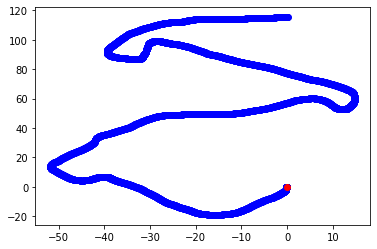

In [8]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

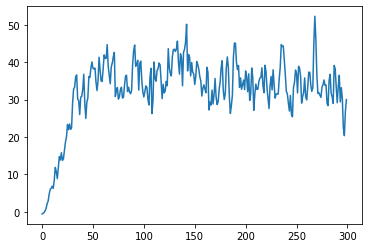

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

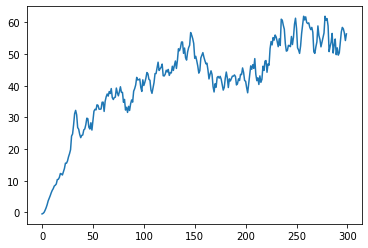

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

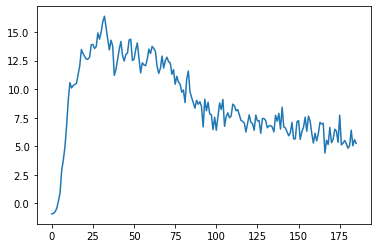

In [5]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/v2.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
